# Mass-Spring-Damper System: Postprocessing the FNN for the Branch

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.getcwd()+'/../../../../../../../'
ROMNet_fld     = WORKSPACE_PATH + '/ROMNet/romnet/'

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

# plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/zoomed.mplstyle')
# plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle')
# plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle')


from PCAfold         import PCA          as PCAA

from scipy.integrate import solve_ivp
import pyDOE


import romnet                             as rmnt

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Data

In [2]:
PCAType         = 'All'
i_red           = 1

# PCAType         = 'OneByOne'
# i_red           = 1 


if (PCAType == 'OneByOne'):
    path_to_run_fld = WORKSPACE_PATH + '/ROMNet/MSD_100Cases_PCA_'+str(i_red)+'_Branch_'+str(i_red)+'/FNN/Run_1/'
elif (PCAType == 'All'):
    path_to_run_fld = WORKSPACE_PATH + '/ROMNet/MSD_100Cases_PCA_All_Branch_'+str(i_red)+'/FNN/Run_1/'

FigDir          = WORKSPACE_PATH+'/../Desktop/Paper_Figures_DeepONet/'


TrainingCases   = [0]#[0,2,4,6,8]
TestCases       = [0,2,4]#[0,2]

NSamples        = 100

Nt              = 100
tout            = np.linspace(0.,15.,Nt)
SOLVER          = 'Radau'


LineVec         = ['-',':','--','.-']*10
ColorVec        = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/POD/MassSpringDamper/FNN/../../../../../../..//ROMNet/MSD_100Cases_SVD_All_Branch_1/FNN/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - fnn.py                    ]:   Constructing Feed-Forward Network: 
[ROMNet - system_of_components.py   ]:     Constructing System of Components: FNN
[ROMNet - component.py              ]:       Constructing Component: FNN
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x18bbaeee0>, <keras.layers.core.dense.Dense object at 0x18beaa5b0>, <keras.layers.core.dropout.Dropout object at 0x18bf066a0>, <keras.layers.core.dense.Dense object at 0x18bf064c0>, <keras.layers.core.dropout.Dropout object at 0x18be6adc0>, <keras.layers.core.dense.Dense object at 0x18be6ad60>, <keras.layers.core.dropout.Dropout object at 0x18be6a4c0>, <keras.layers.core.dense.Dense object at 0x18be6a8b0>])

[ROMNet - model_tf.py    ]:   Loading ML Model Parameters from

## Evaluating Branch on Test Data

i_mode =  0


Text(0, 0.5, '$\\alpha_{x_1}$, from FNN')

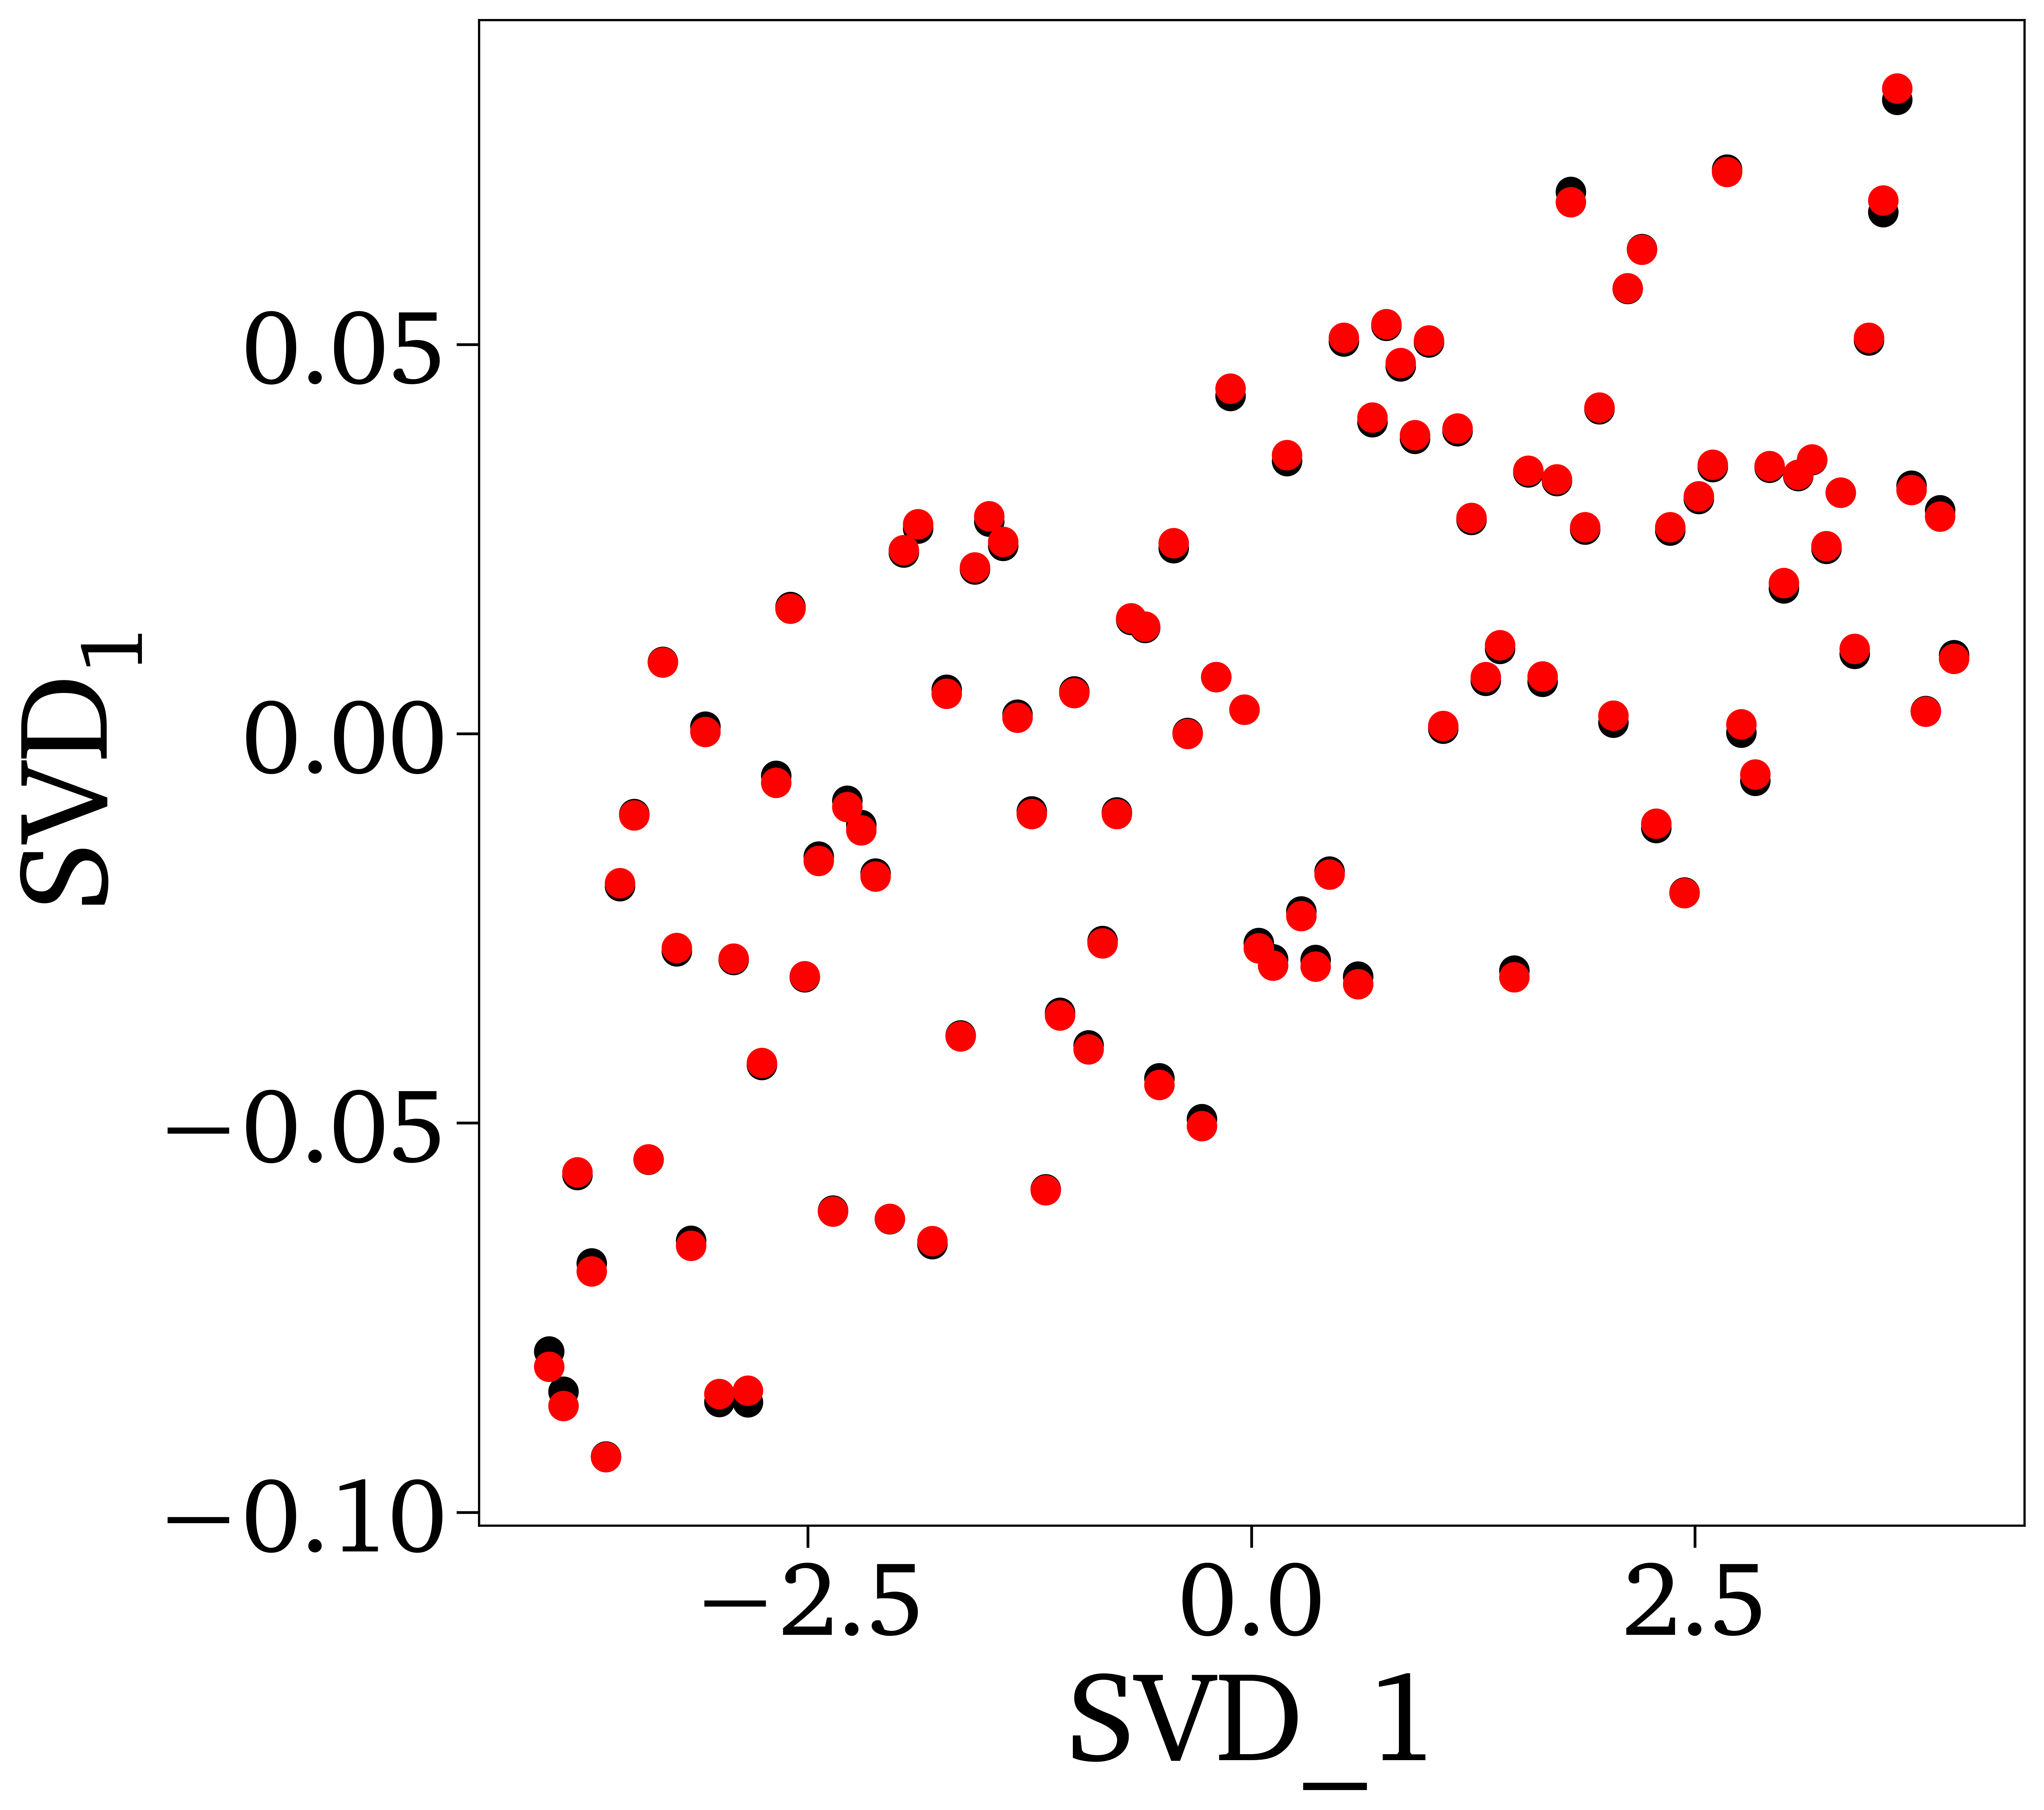

In [5]:
VarOI      = 'PCA_1'
iVar       = 0

Vars       = ['PCA_'+str(i_mode+1) for i_mode in range(InputData.n_modes)]+['C','D']

FileName   = InputData.path_to_data_fld + '/test/ext/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
Input      = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = InputData.path_to_data_fld + '/test/ext/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
Output     = Data.to_numpy()

FileName   = InputData.path_to_data_fld + '/train/pts/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
InputTrain = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = InputData.path_to_data_fld + '/train/pts/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
OutputTrain= Data.to_numpy()

FileName   = InputData.path_to_data_fld + '/valid/pts/Input.csv'# + InputData.InputFile
DataIn     = pd.read_csv(FileName, header=0)
InputValid = DataIn.to_numpy()
VarNames   = list(DataIn.columns)

FileName   = InputData.path_to_data_fld + '/valid/pts/Output.csv'# + InputData.InputFile
Data       = pd.read_csv(FileName, header=0)
OutputValid= Data.to_numpy()

## Variable to Be Visualized
for i_mode in range(len(Vars)):
    if (Vars[i_mode] == VarOI):
        print('i_mode = ', i_mode)
        break

        
yMat      = model.predict(Input)    
yMatTrain = model.predict(InputTrain)    
yMatValid = model.predict(InputValid)    

plt.figure(figsize=(10,10))
plt.plot(Input[:,iVar], Output[:,i_mode], 'ko')
plt.plot(Input[:,iVar], yMat[:,i_mode], 'ro')
# plt.plot(InputTrain[:,iPC], OutputTrain[:,iVar], 'ko')
# plt.plot(InputTrain[:,iPC], yMatTrain[:,iVar], 'ro')
# plt.plot(InputValid[:,iPC], OutputValid[:,iVar], 'bo')
# plt.plot(InputValid[:,iPC], yMatValid[:,iVar], 'go')
plt.xlabel(Vars[iVar])
plt.ylabel(r'$'+VarOI+'$')
#plt.xlim([1.e-6,1.e-2])
#plt.legend()
#plt.show()

MinFact = 1.e-3
MaxFact = 1.5

plt.figure(figsize=(10,10))
plt.plot(OutputTrain[:,i_mode], yMatTrain[:,i_mode], 'ko')
plt.plot(OutputValid[:,i_mode], yMatValid[:,i_mode], 'bo')
plt.plot([yMatTrain[:,i_mode].min()-0.1, yMatTrain[:,i_mode].max()*MaxFact],[yMatTrain[:,i_mode].min()-0.1, yMatTrain[:,i_mode].max()*MaxFact], 'k-')
plt.xlabel(r'$\alpha_{x_'+str(i_mode+1)+'}$'+', from PCA')
plt.ylabel(r'$\alpha_{x_'+str(i_mode+1)+'}$'+', from FNN')
#plt.xlim([yMatTrain[:,iVar].min()*MinFact, yMatTrain[:,iVar].max()*MaxFact])
#plt.ylim([yMatTrain[:,iVar].min()*MinFact, yMatTrain[:,iVar].max()*MaxFact])

In [6]:
# %matplotlib qt

if (i_red == 1):
    Var    = 'x_'
    ColorA = ColorVec[1]
    ColorB = ColorVec[2]
else:
    if (i_red == 2):
        Var = 'v_'
    else:
        Var    = ''
    ColorA = ColorVec[0]
    ColorB = ColorVec[3]
    
fig = plt.figure(figsize=(12,12))
ax  = fig.add_subplot(projection='3d')

ax.scatter(Input[:,0], Input[:,1], Output[:,0], marker='o', c=ColorA, s=80, label='PCA')
ax.scatter(Input[:,0], Input[:,1], yMat[:,0],   marker='^', c=ColorB, s=80, label='FNN')

ax.scatter(Input[:,0], Input[:,1], Output[:,1], marker='o', c=ColorA, s=80)
ax.scatter(Input[:,0], Input[:,1], yMat[:,1],   marker='^', c=ColorB, s=80)

ax.legend(loc=2, framealpha=0.1)

ax.set_xlabel('\n\n'+r'$x_{0} [m]$', rotation = 0)
ax.set_ylabel(r'                $v_{0} [m/s]$', rotation = 0)
ax.set_zlabel(r'        $\alpha_{'+Var+'i}$', rotation = 0)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

if (FigDir):
    if (PCAType == 'OneByOne'):
        plt.savefig(FigDir+'/MSD_OneByOne_Branch_'+str(i_red)+'.eps', format='eps', bbox_inches='tight')
    elif (PCAType == 'All'):
        plt.savefig(FigDir+'/MSD_All_Branch_'+str(i_red)+'.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Plotting Loss Histories

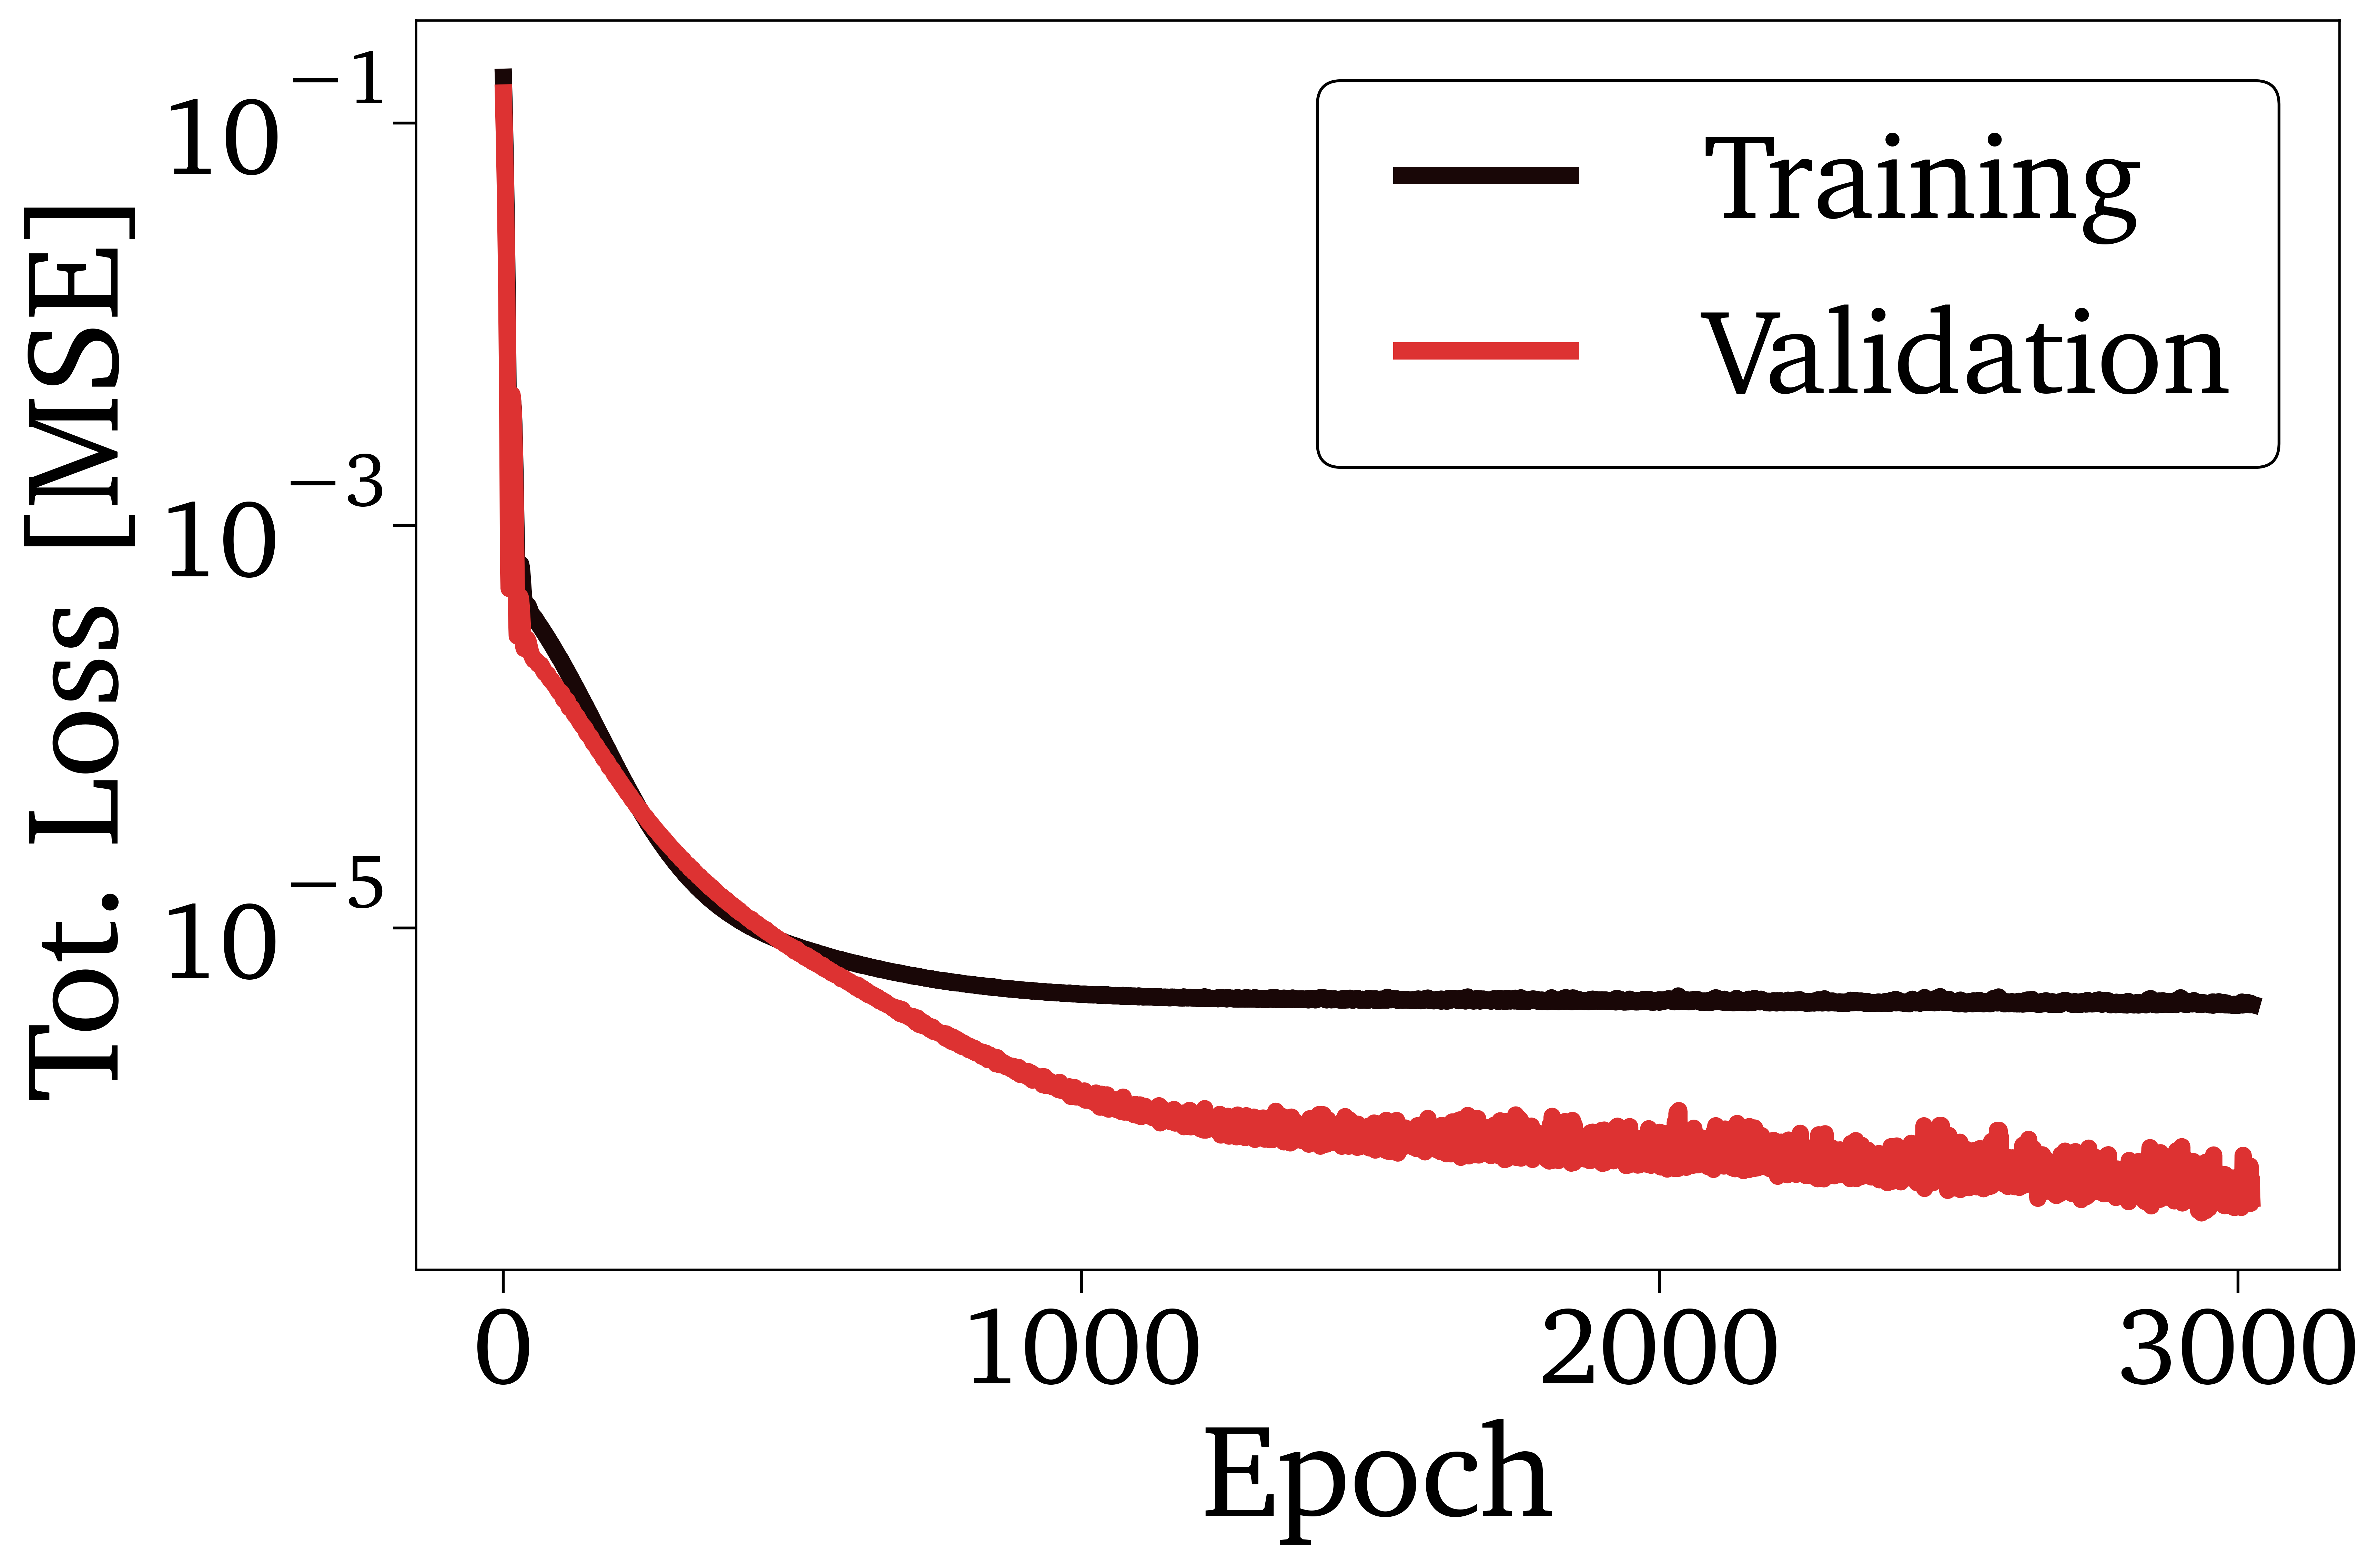

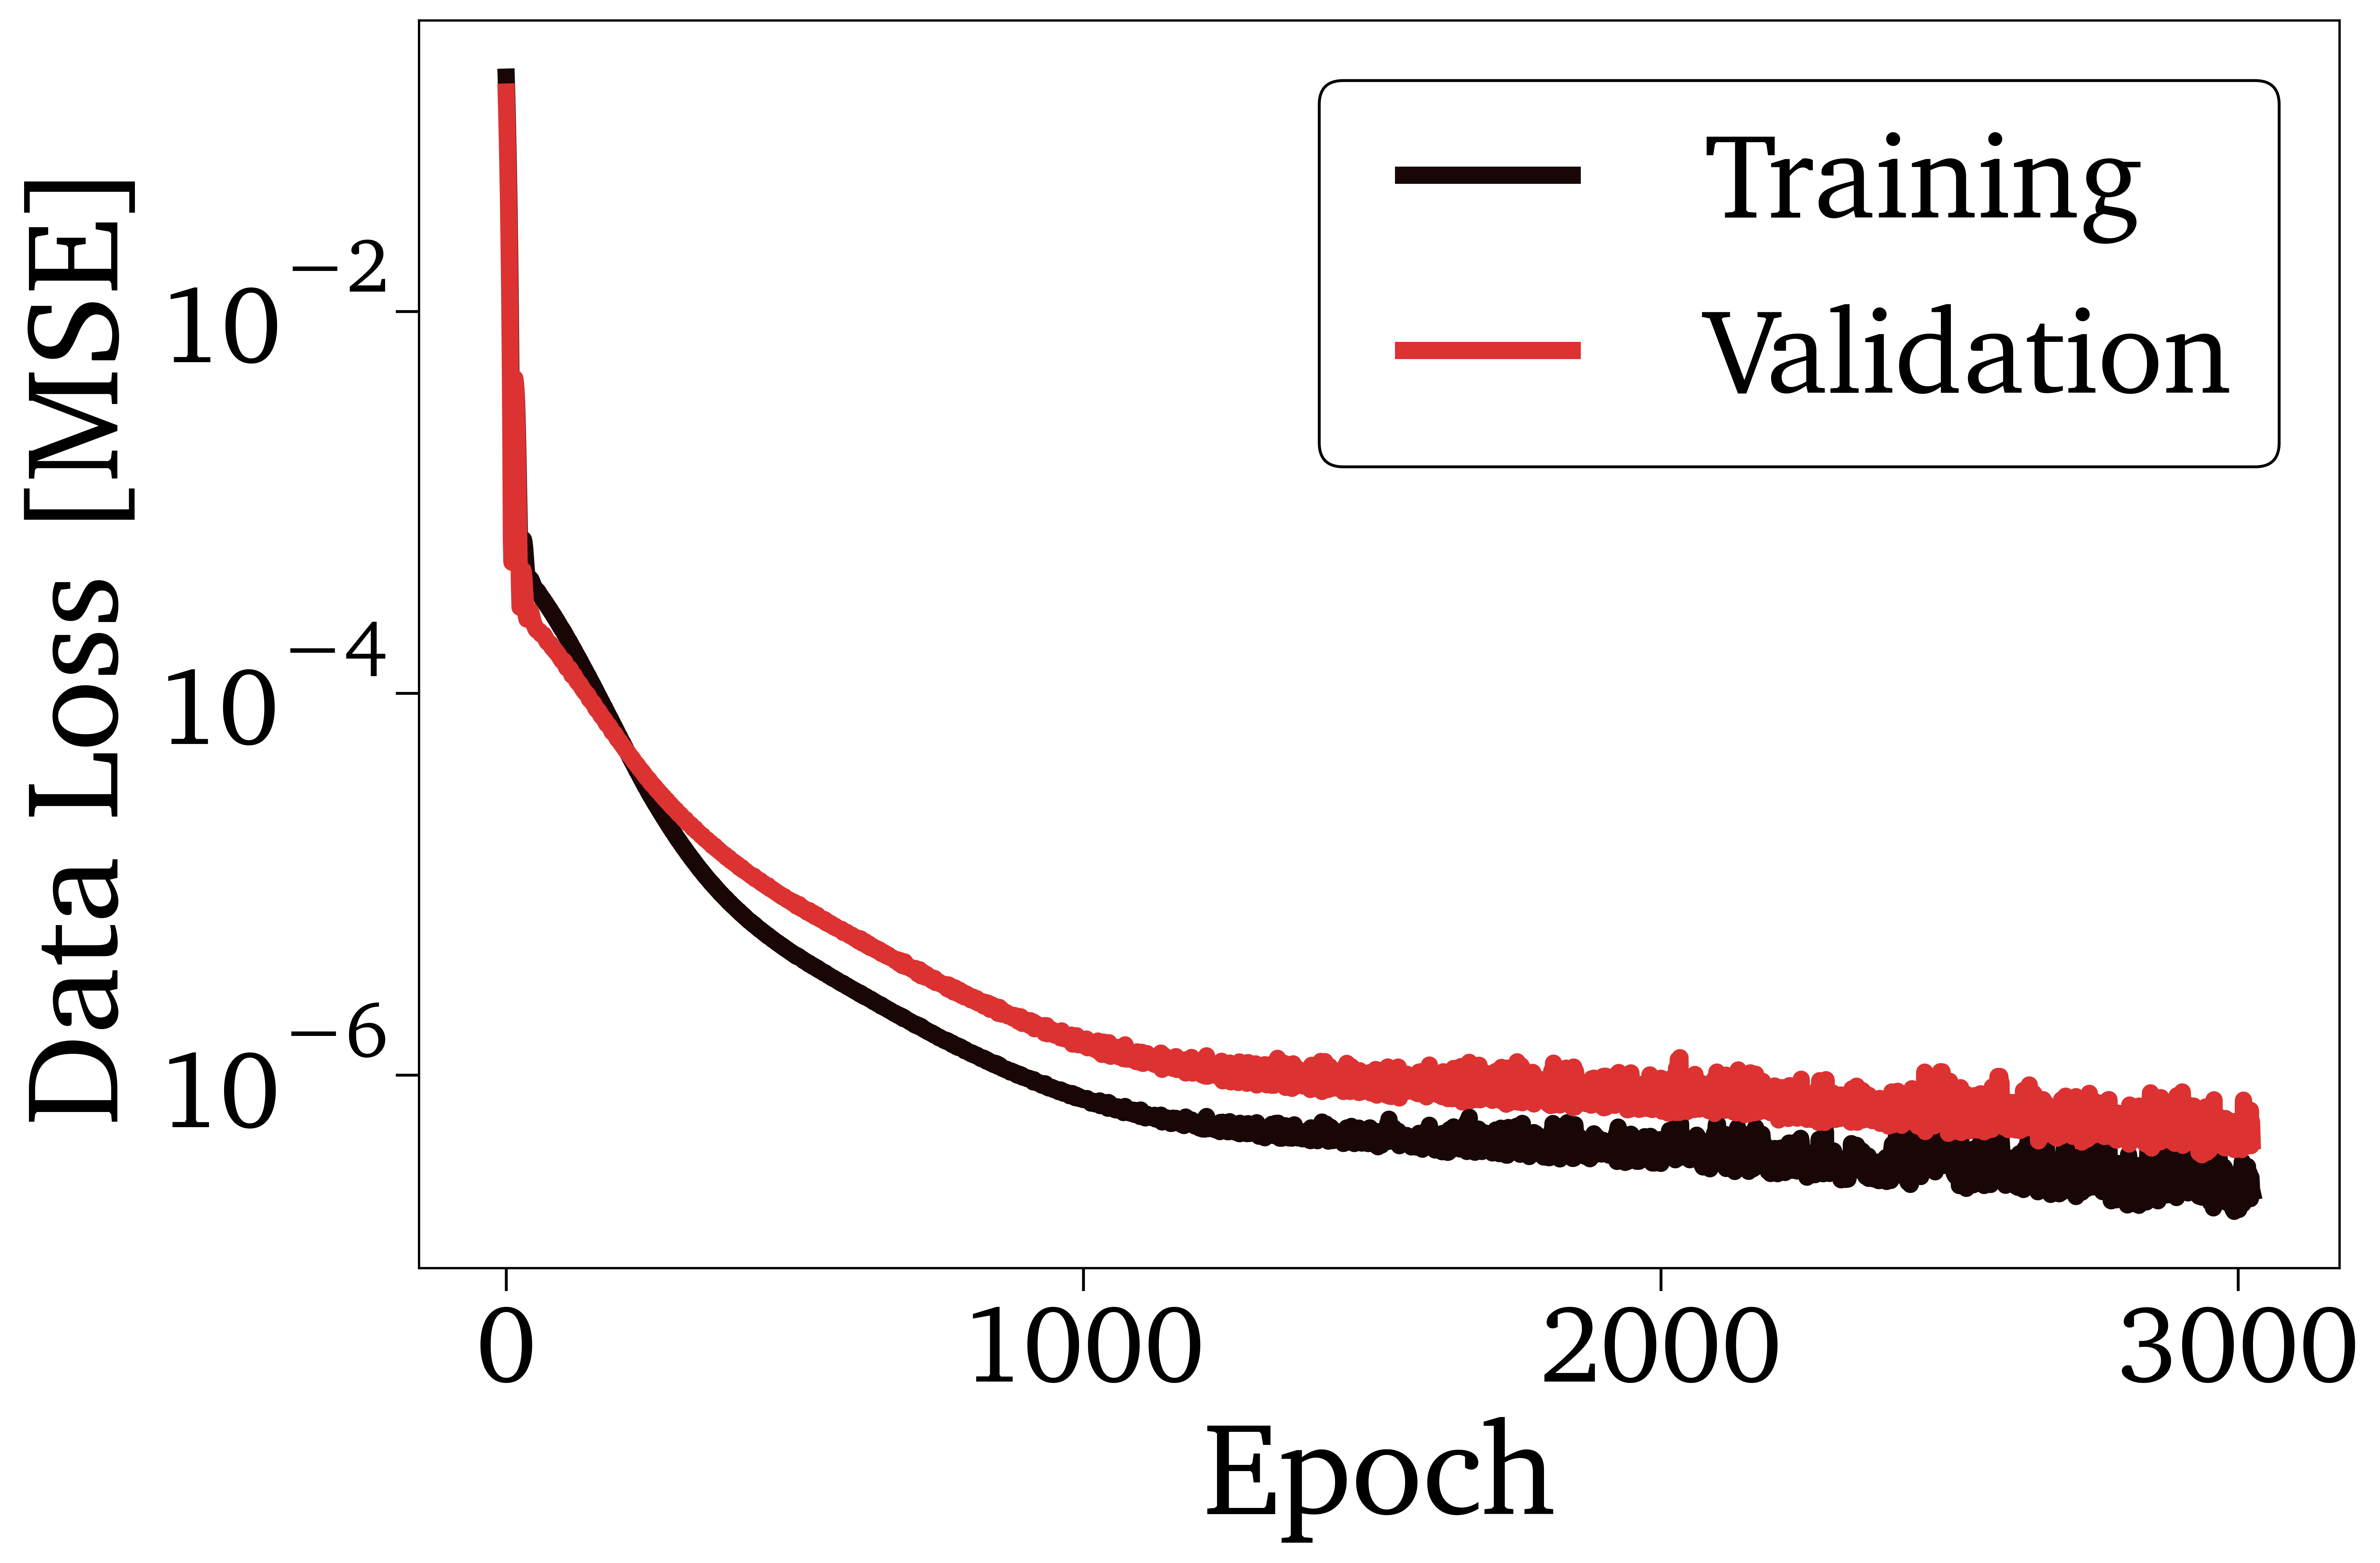

In [7]:
Data    = pd.read_csv(path_to_run_fld+'/Training/History.csv')

# OldRun  = 'Run_39'
# DataOld = pd.read_csv(path_to_run_fld+'/../'+OldRun+'/Training/History.csv')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['tot_loss'],      label='Training')
plt.plot(Data['val_tot_loss'],  label='Validation')
# plt.plot(DataOld['tot_loss'],     label='Training, '+OldRun)
# plt.plot(DataOld['val_tot_loss'], label='Validation, '+OldRun)
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

fig  = plt.figure(figsize=(12,8))
plt.plot(Data['pts_loss'],      label='Training')
plt.plot(Data['val_pts_loss'],  label='Validation')
# plt.plot(DataOld['pts_loss'],     label='Training, '+OldRun)
# plt.plot(DataOld['val_pts_loss'], label='Validation, '+OldRun)
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')
#plt.ylim([1.e-2, 1.e0])

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Writing Branch's Parameter in the Fina.hdf5 File for Future DeepONet's Transfer/Generative Learning

In [8]:
import h5py
import tensorflow as tf
from keras    import backend
from keras    import __version__ as keras_version  # pylint: disable=g-import-not-at-top
from keras.saving import saving_utils


def _legacy_weights(layer):
    """DO NOT USE.
    For legacy reason, the layer.weights was in the order of
    [self.trainable_weights + self.non_trainable_weights], and this order was
    used for preserving the weights in h5 format. The new order of layer.weights
    are the same as layer.get_weights() which is more intuitive for user. To
    keep supporting the existing saved h5 file, this method should be used to
    save/load weights. In future version, we will delete this method and
    introduce a breaking change for h5 and stay with the new order for weights.
    Args:
    layer: a `tf.keras.Model` or `tf.keras.layers.Layer` instance.
    Returns:
    A list of variables with the order of trainable_weights, followed by
      non_trainable_weights.
    """
    weights = layer.trainable_weights + layer.non_trainable_weights
    if any(not isinstance(w, tf.Variable) for w in weights):
        raise NotImplementedError(
            f'Save or restore weights that is not an instance of `tf.Variable` is '
            f'not supported in h5, use `save_format=\'tf\'` instead. Received a '
            f'model or layer {layer.__class__.__name__} with weights {weights}')
    return weights



def save_attributes_to_hdf5_group(group, name, data):
    HDF5_OBJECT_HEADER_LIMIT = 64512
    
    bad_attributes = [x for x in data if len(x) > HDF5_OBJECT_HEADER_LIMIT]

    # Expecting this to never be true.
    if bad_attributes:
        raise RuntimeError('The following attributes cannot be saved to HDF5 '
                           'file because they are larger than %d bytes: %s' %
                           (HDF5_OBJECT_HEADER_LIMIT, ', '.join(bad_attributes)))

    data_npy = np.asarray(data)

    num_chunks = 1
    chunked_data = np.array_split(data_npy, num_chunks)

    # This will never loop forever thanks to the test above.
    while any(x.nbytes > HDF5_OBJECT_HEADER_LIMIT for x in chunked_data):
        num_chunks += 1
        chunked_data = np.array_split(data_npy, num_chunks)

    if num_chunks > 1:
        for chunk_id, chunk_data in enumerate(chunked_data):
            group.attrs['%s%d' % (name, chunk_id)] = chunk_data
    else:
        group.attrs[name] = data

        
def load_attributes_from_hdf5_group(group, name):
    """Loads attributes of the specified name from the HDF5 group.
    This method deals with an inherent problem
    of HDF5 file which is not able to store
    data larger than HDF5_OBJECT_HEADER_LIMIT bytes.
    Args:
      group: A pointer to a HDF5 group.
      name: A name of the attributes to load.
    Returns:
      data: Attributes data.
    """
    if name in group.attrs:
        data = [
            n.decode('utf8') if hasattr(n, 'decode') else n
            for n in group.attrs[name]
        ]
    else:
        data = []
        chunk_id = 0
        while '%s%d' % (name, chunk_id) in group.attrs:
            data.extend([
              n.decode('utf8') if hasattr(n, 'decode') else n
              for n in group.attrs['%s%d' % (name, chunk_id)]
          ])
        chunk_id += 1
    return data


def save_weights_to_hdf5_group(f, layers, old_string, new_string):

    layer_names_temp = load_attributes_from_hdf5_group(f_new, 'layer_names')
    layer_names_old  = []
    for layer in layer_names_temp:
        layer_names_old.append(layer.encode('utf8'))
    
    layer_names = []
    for layer in layers:
        print(layer.name)
        if (old_string in layer.name):
            layer_name = layer.name.replace(old_string, new_string) #############
            layer_names.append(layer_name.encode('utf8'))
            layer._name = layer_name

    save_attributes_to_hdf5_group(f, 'layer_names', layer_names+layer_names_old)
    f.attrs['backend'] = backend.backend().encode('utf8')
    f.attrs['keras_version'] = str(keras_version).encode('utf8')

    # Sort model layers by layer name to ensure that group names are strictly
    # growing to avoid prefix issues.
    for layer in sorted(layers, key=lambda x: x.name):
        if (new_string in layer.name):
            layer_name    = layer.name.replace(old_string, new_string) ############# 
            g             = f.create_group(layer_name)
            weights       = _legacy_weights(layer)
            weight_values = backend.batch_get_value(weights)

            weight_names = []
            for w in weights:
                w_name = w.name.replace(old_string, new_string) ############# 
                weight_names.append(w_name.encode('utf8'))
            #weight_names = [w.name.encode('utf8') for w in weights]
            save_attributes_to_hdf5_group(g, 'weight_names', weight_names)
            for name, val in zip(weight_names, weight_values):
                param_dset = g.create_dataset(name, val.shape, dtype=val.dtype)
                if not val.shape:
                    # scalar
                    param_dset[()] = val
                else:
                    param_dset[:] = val

In [9]:
try:
    os.makedirs(InputData.path_to_data_fld+'/../../FNN/')
except:
    pass
filename_new = InputData.path_to_data_fld+'/../../FNN/Final.h5'

f_new        = h5py.File(filename_new, 'a')

save_weights_to_hdf5_group(f_new, NN.layers, 'FNN-FNN', 'DeepONet-Branch_'+str(i_red))

f_new.close()

OSError: Unable to create file (unable to open file: name = '/Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/POD/MassSpringDamper/FNN/../../../../../../..//ROMNet/romnet//../Data/MSD_100Cases/Orig/All/SVD_All/Branch_1//../../FNN/Final.h5', errno = 17, error message = 'File exists', flags = 15, o_flags = a02)

In [ ]:
f_new.close()

In [ ]:
f_new        = h5py.File(filename_new, 'a')

data = load_attributes_from_hdf5_group(f_new, 'layer_names')
data

f_new.close()

# 